<a href="https://colab.research.google.com/github/volgasezen/is584/blob/main/Lab 6/1 - NLP_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="margin-bottom:0">IS 584: Deep Learning for Text Analytics</center></h1>
<br>
<h3 style="margin-top:0">Lab 6: RNN Based Text Generator</center></h2>
<h4 style="margin-top:0">Given by Volga Sezen</center></h4>
<i>

Thanks to Arif Ozan Kızıldağ

</i></center>
<br>

-----------

In this tutorial, we will explore Recurrent Neural Networks (RNNs) by creating a character-level language model that will generate text similar to Shakespeare's works. For this purpose, we will use the `tiny Shakespeare` data set prepared by Andrej Karpaty mentioned in his blog post [The Unreasonable Effectiveness of Recurrent Neural Networks]( http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In the previous tutorials, we used `TorchText` to process the data and create batches, but this time we will write simple function for processing the data and creating batches.

Let’s start by importing the required libraries.


In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# Recap on LSTM


Before we continue onto the example, let’s recap LSTM and PyTorch functions on RNN architecture. 

PyTorch has a few [different RNN](https://pytorch.org/docs/stable/nn.html#recurrent-layers) approaches: Cell and multilayer methods. The cell method creates a single cell for that method. For example, [nn.LSTMCell](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html#torch.nn.LSTMCell) creates a single LSTM block. On the other hand [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) creates an LSTM architecture with a single or multiple layers.


As mentioned previously, we will be using the LSTM model. Let’s start with the `nn.LSTM` function. Let's go over its parameters first;
* input_size: This is the size of inputs. In our case, it will be equal to the embedding size.
* hidden_size:  It is the size of the hidden state h. (It is also equal to the size of the cell state c).
* num_layers: It is the depth of the LSTM (i.e. stacked LSTM). Its default value is 1. 
* bias: Whether the layers have biases or not. Its default value is True.
* batch_first: Similar to the other functions in PyTorch/TorchText, if true, it orders input and outputs as batch, seq, and feature. Its default value is false.
* dropout: If it is not zero, dropout is applied to the end of each layer ***except the last one***. Its default value is 0.
* bidirectional: If set true, it changes architecture to Bidirectional LSTM. Its default value is False.


In [2]:
rnn = nn.LSTM(10, 20, 2) #input_size, hidden_size, num_layers
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)  #num_layers, batch_size, hidden_size
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

As you can see from the above example, we have an embedding size of 10, hidden sizes of 20, and a 2-layer LSTM architecture. The hidden layer (cell state) is a three-dimensional tensor with dimensions equal to num_layers, batch_size, and hidden size. While calling the LSTM layer, we will feed our input and hidden states to our function. Please note that for the LSTM layer, you need to convert hidden and cell states as a tuple.

nn.LSTM module also works if we don’t give any hidden state. In this case, it will automatically create zero-tensors for hidden states.

PyTorch uses the following formulation of gates and layers:

$ i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi}) \\
f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf}) \\
g_t = \tanh(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg}) \\
o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho}) \\
c_t = f_t c_{t-1} + i_t \odot g_t \\
h_t = o_t \odot \tanh(c_t) $

where:
* $h_t$​ is the hidden state at time $t$, 
* $c_t$​ is the cell state at time $t$, 
* $x_t$​ is the input at time t, 
* $h_{t-1}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time 0, and 
* $i_t​, f_t, g_t, o_t$ are the input, forget, cell, and output gates, respectively. 

$\sigma$ is the sigmoid function, and $\odot$ is the Hadamard product. 

Official documentation where the explanations were taken from: [`torch.nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

Let's try to visualize this information. Before we start, here is a graph for overall LSTM architecture.

![1_mcHP77YF63SuqUGAIiBBsA[1].jpeg](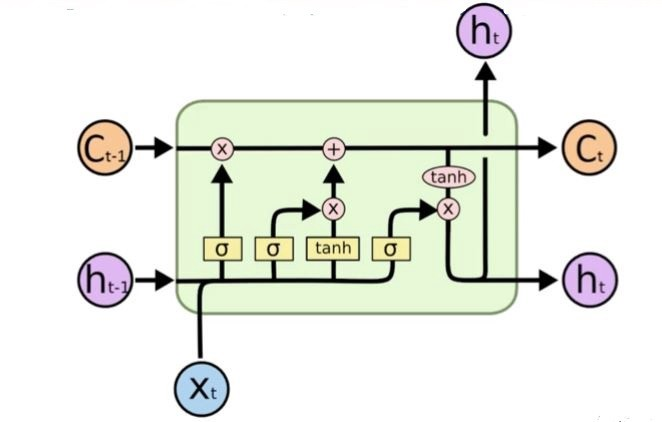)

Image taken from: [https://medium.datadriveninvestor.com/time-series-predictions-with-lstm-4877c38d87d1](https://medium.datadriveninvestor.com/time-series-predictions-with-lstm-4877c38d87d1)

## Loading Data

Let us start getting our data. If you are using Google Colab, you may want to install `input.text` to your drive.

In [3]:
!wget https://github.com/karpathy/char-rnn/raw/master/data/tinyshakespeare/input.txt

--2025-04-13 14:49:54--  https://github.com/karpathy/char-rnn/raw/master/data/tinyshakespeare/input.txt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt [following]
--2025-04-13 14:49:55--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

     0K .......... .......... .......... .......... ..........  4% 1.16M 1s
    50K .......... .......... .......... .......... ..........  9% 1.46M 1s
   100K .......

In [4]:
with open('input.txt', 'r') as f:
    text = f.read()

## Data preparation

First, we need easy access to characters to create a character-level language model. Luckily, because our data is a string (i.e., char-array), we can easily access characters from text.

In [5]:
print("\033[1m"+'First 100 characters:\n'+"\033[0m",text[:100])  # In chararray
print("\033[1m"+'\n3891st character:\n'+"\033[0m", text[3891]) 

First 100 characters:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

3891st character:
 v


Again, due to the nature of the character-level language model, we don’t need tokenization. We only need to create our vocabulary and dictionaries to convert characters to int and int to the character.

In [6]:
chars = tuple(set(text))    #get characters present in the text
int2char = dict(enumerate(chars))   #dictionary for int to character conversion
char2int = {ch: i for i, ch in int2char.items()} #dictionary for character to int conversion

text_as_int = np.array([char2int[ch] for ch in text])  #convert all text
print('Length of the vocabulary: ', len(chars))
print("Character 'a' is" ,char2int['a'],"and char 'A' is ", char2int['A'])
print("\033[1m"+'First 100 characters as int :\n'+"\033[0m",text_as_int[:100])  #show first 100 characters

Length of the vocabulary:  65
Character 'a' is 43 and char 'A' is  48
First 100 characters as int :
 [30 17 44 19 57 58 15 17 57 17 50 12  7 27  6  3 12 35 32 44 12 58  4 12
 58 47 44 32 56 12 12 24 58 43  7  8 58 35 10 44 57 45 12 44 16 58 45 12
 43 44 58 22 12 58 19 47 12 43 62  1  6  6 48  2  2 27  6 25 47 12 43 62
 16 58 19 47 12 43 62  1  6  6 30 17 44 19 57 58 15 17 57 17 50 12  7 27
  6 23 32 10]


Because we have such a small vocabulary, instead of using embeddings, we can easily use it with one hot encoded vectors with size 65.

In [7]:
def one_hot_encode(int_array , u_char):  #input array of ints and char vocbulary 
    
    one_hot = np.zeros((np.multiply(*int_array.shape), u_char), dtype=np.float32)  #create empty array
    one_hot[np.arange(one_hot.shape[0]), int_array.flatten()] = 1.  #set appropiate column as 1
    one_hot = one_hot.reshape((*int_array.shape, u_char))
    return one_hot

In [8]:
one_hot_encode(np.array([[1],[2]]),5)

array([[[0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0.]]], dtype=float32)

<img src='http://karpathy.github.io/assets/rnn/charseq.jpeg' width='350'>


Now that we have a way to create one-hot vectors, we need to create our batches. Our output needs to be one shifted version of the inputs due to RNN architecture. For example, while our input is 'hell our output needs to be ‘ello’.

Because our input data is plain text, in addition to our batch size, we need to determine how many characters we need to put in each batch.


In [9]:
def batch_create(arr, batch_size, char_num):  #arr is data, char_num is character number at a data point and batch size is number of data point contained in a batch
    batch_size_total = batch_size * char_num
    n_batches = len(arr)//batch_size_total
    
    arr = arr[:n_batches * batch_size_total] #remove extra chracters from data

    arr = arr.reshape((batch_size, -1)) #convert to batch sizes
    
    for n in range(0, arr.shape[1], char_num): # we need to create output  and input data by shifting them
        input_data = arr[:, n:n+char_num]
        output_data = np.zeros_like(input_data)
        try:
            output_data[:, :-1], output_data[:, -1] = input_data[:, 1:], arr[:, n+char_num]
        except IndexError:
            output_data[:, :-1], output_data[:, -1] = input_data[:, 1:], arr[:, 0]
        yield input_data, output_data

In [10]:
next(batch_create(text_as_int,4,4))

(array([[30, 17, 44, 19],
        [58, 45, 32,  4],
        [12, 58, 35,  2],
        [ 2,  2, 58, 32]]),
 array([[17, 44, 19, 57],
        [45, 32,  4, 58],
        [58, 35,  2, 43],
        [ 2, 58, 32,  7]]))

# Network

PyTorch neural network module ([torch.nn ]( https://pytorch.org/docs/stable/nn.html#recurrent-layers)) provides easy access to RNN architectures. It provides both a single-cell and multi-layer architecture with multiple layers.
In this example, we will use `torch.nn.LSTM`, a multi-layer LSTM module.


In [11]:
class CharLSTM(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2, lr=0.001):
        super().__init__()
        #Let’s put the parameters inside the function for ease of access, and when we save our network parameters will stay with it.
        self.n_layers = n_layers     
        self.n_hidden = n_hidden
        self.lr = lr
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, dropout=0.5, batch_first=True)  #lstm layer with 0.5 dropout
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(n_hidden, len(self.chars)) # linear layer to calculate
      
    
    def forward(self, x, hidden):              
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden) #convert to 1 dimension   
        out = self.fc(out)
        
        return out, hidden
    
    
    def init_hidden(self, batch_size): #creates hidden layer parameters.
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
              weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())

        return hidden

# Training

Now that our network is ready lets start training our network

In [12]:
n_hidden=512
n_layers=2
net = CharLSTM(chars, n_hidden, n_layers).cuda()
print(net)

CharLSTM(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)


In [13]:
opt = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [14]:
from time import time
start = time()
batch_size = 128
seq_length = 100
epochs = 40
net.train()

val_idx = int(len(text_as_int)*(0.9)) #select %90/10 split
data, val_data = text_as_int[:val_idx], text_as_int[val_idx:]


counter = 0
n_chars = len(net.chars)
for e in range(epochs):
    h = net.init_hidden(batch_size)
    
    for x, y in batch_create(data, batch_size, seq_length):
        counter += 1  #counter for printing
        
        x = one_hot_encode(x, n_chars)    #encode the data
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
        inputs, targets = inputs.cuda(), targets.cuda()

        h = tuple([each.data for each in h]) #creating new h for new batch to prevent backprobation for all h
        
        net.zero_grad()
        output, h = net(inputs, h)
        loss = loss_fn(output, targets.view(batch_size*seq_length).long())
        loss.backward()

        nn.utils.clip_grad_norm_(net.parameters(), 5)  #clip at parameters higher than 5 for preventing exploding gradient problem
        opt.step()
        
        if counter % 50 == 0: #print every 50 step
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for x, y in batch_create(val_data, batch_size, seq_length):
                x = one_hot_encode(x, n_chars)
                x, y = torch.from_numpy(x), torch.from_numpy(y)
                val_h = tuple([each.data for each in val_h]) #creating new h for new batch to prevent backprobation for all h
                
                inputs, targets = x.cuda(), y.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = loss_fn(output, targets.view(batch_size*seq_length).long())
            
                val_losses.append(val_loss.item())
            
            net.train() # reset to train mode after iterationg through validation data
            
            print(f'Epoch: {e+1}/{epochs}... Step: {counter}... Loss: {loss.item():.4f}... Val Loss: {np.mean(val_losses):.4f}')
end=time()
cpu_time = end - start
print(f'{cpu_time:.2f} seconds')

Epoch: 1/40... Step: 50... Loss: 3.3373... Val Loss: 3.3384
Epoch: 2/40... Step: 100... Loss: 3.2816... Val Loss: 3.2864
Epoch: 2/40... Step: 150... Loss: 2.9149... Val Loss: 2.8724
Epoch: 3/40... Step: 200... Loss: 2.5948... Val Loss: 2.5345
Epoch: 4/40... Step: 250... Loss: 2.4218... Val Loss: 2.3606
Epoch: 4/40... Step: 300... Loss: 2.3050... Val Loss: 2.2549
Epoch: 5/40... Step: 350... Loss: 2.2265... Val Loss: 2.1729
Epoch: 6/40... Step: 400... Loss: 2.1518... Val Loss: 2.0952
Epoch: 6/40... Step: 450... Loss: 2.0800... Val Loss: 2.0449
Epoch: 7/40... Step: 500... Loss: 2.0221... Val Loss: 2.0027
Epoch: 8/40... Step: 550... Loss: 1.9766... Val Loss: 1.9551
Epoch: 8/40... Step: 600... Loss: 1.9124... Val Loss: 1.9252
Epoch: 9/40... Step: 650... Loss: 1.8724... Val Loss: 1.8968
Epoch: 9/40... Step: 700... Loss: 1.8273... Val Loss: 1.8762
Epoch: 10/40... Step: 750... Loss: 1.8070... Val Loss: 1.8461
Epoch: 11/40... Step: 800... Loss: 1.7858... Val Loss: 1.8140
Epoch: 11/40... Step: 8

# Saving model 

Now that our training is done, we can save our network using the `torch.save()` command to use later. (If you can also integrate this command into the training loop to save your model in regular intervals)

In [19]:
# Saving the model
model_name = 'LSTM.net'
checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

In [20]:
with open(model_name, 'wb') as f:  # in this case we will save it to drive folder that we opened in begining of this tutorial.
    torch.save(checkpoint, f)

Of course, you may want to move files to local storage or connect to Google drive.

# Prediction

We created our network, trained it, and saved it. The last thing we need to do is to create text similar to Shakespeare’s works. Our problem now is that when we give the network an initial set of characters, we will obtain the same output every time if we select the output with the highest probability.

To solve this, we will apply the topk prediction approach. This method gives random probability to k words according to their weights. For example, if we want to apply using two characters, and the highest valued characters are ‘a' with 0.7 and ‘e' with 0.1 using this approach, the random model will select ‘a' with 87.5% probability and ‘e' with 12.5% probability. Using the topk method when we run the code, we can obtain different results each time we run the algorithm.


In [17]:
def predict(net, char, h=None):  #created function for top k prediction
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x).cuda()
             
        h = tuple([each.data for each in h]) #again preventing backprobagation
        out, h = net(inputs, h)

        p = F.softmax(out, dim=1).data.cpu()  #sofmax here due to preventing softmaxing whole data

        p, top_ch = p.topk(5)   #choose 5 elements and choose add a probability choice
        top_ch = top_ch.numpy().squeeze()
        p = p.numpy().squeeze()
        output = np.random.choice(top_ch, p=p/p.sum())

        return net.int2char[output], h

In [18]:
first_chars='A man'       
net.eval()

chars = [ch for ch in first_chars]
h = net.init_hidden(1)
for ch in first_chars:
    char, h = predict(net, ch, h)

chars.append(char)

for ii in range(500): #find next 100 characters
    char, h = predict(net, chars[-1], h)
    chars.append(char)

output= ''.join(chars)

print(output)

A man,
Was he was not all service.

CORIOLANUS:
Ay, that he shall be such and father's death,
To have my honour is answer, and here's
But steal the cale and sea that says, and honest
With heres before a blenting frame to be this:
Well he done to thy, to hend thanks.

Second Catisin:
How say the mighty will they would have speak me?
If I was a ten to be thunk to say.

CAPULET:
If they have dare to stir as any strange;
And thus this lives of answer'd hate is spreath
But with the still, but which how he 
